# 1 Initialize the model and simulations

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Translation.model as mdl
from collections import defaultdict
import Sensitivity.Pathway_Analysis.sensitivity as sa
from Simulation.Simulator_Python.simulator_interface import setup_and_create_rules, setup_and_run_simulation
from Sensitivity.Pathway_Analysis.weighted_directed_network import WDN_Model
from Sensitivity.Pathway_Analysis.extract_pathways import EXTRACT_PATHS
from Visualization.visualize_sensitivity import plot_bar, plot_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
EXAMPLESPATH = '../../MeLoDy/framework/examples/'

In [3]:
# Make sure your working directory is in ../framework/examples
os.getcwd()

'/Users/gaoxiangzhou/Downloads/biodesignlab-framework-2c33a1ab1b5f/examples'

# 2 Begin Discrete Static/Dynamic Sensitivity Analysis

In [4]:
# set up scenarios
base_name = 'wm_translation_2'
model_excel = 'models/' + base_name + '.xlsx'
#model_excel = base_name+'.xlsx'
sens_model = mdl.get_model(model_excel)
scenarios = [x.strip() for x in sens_model.columns if ('initial' in x.lower())]

In [5]:
# define simulation parameters
output_path = 'sensitivity'
steps = 200
runs = 100
scenarios_index = list(range(len(scenarios)))
output_format = 2
scheme = 'ra'

# set up output paths
scenarios_sorted = [str(x) for x in sorted(scenarios_index)]
if not os.path.exists(output_path):
    os.mkdir(output_path)
output_basename = os.path.join(output_path,'example_traces_transpose_' + base_name)

In [6]:
# run simulations
setup_and_run_simulation(
         model_excel,
         output_basename + '.txt', 
         steps, 
         runs, 
         scheme, 
         output_format,
         ','.join(scenarios_sorted)
         )

In [7]:
# For large models or model with densed edges, it is suggested to run it with dynamic sensitivity analysis
# unless it is necessary. Number of levels can be adjusted to decrease running time
l = max(sens_model.Levels.tolist())
edge_num_list = list([max(len(sens_model.Regulators.tolist()[i])-2,0) for i in range(len(sens_model))])
e = sum(edge_num_list)
b = max(edge_num_list)
Complexity = e*(min(6,l))**b
print('Estimated for running time of dynamic sensitivity analysis in sec:', Complexity*0.00002)
print('Estimated for running time of static sensitivity analysis in sec:', Complexity*0.0008)

Estimated for running time of dynamic sensitivity analysis in sec: 19147.6224
Estimated for running time of static sensitivity analysis in sec: 765904.8960000001


In [8]:
# run dynamic sensitivity analysis
# Be patient here, it takes about more than 10 mins for this model
import time
start = time.time()
trace_file = 'sensitivity/example_traces_transpose_' + base_name + '.txt'
dynamic_results_file = 'sensitivity/example_dynamic_analysis_' + base_name
method = 'HB'
status_report = False
sa.run_discrete_dynamic(model_excel, trace_file, dynamic_results_file, method, status_report)
Dmodel = WDN_Model()
with open(dynamic_results_file,'r') as results_file:
    Dmodel.parse_dynamic(results_file)

element_names = sa.get_element_list(Dmodel)
element_sensitivity = sa.get_element_sensitivity(Dmodel)
element_immediate_influences = sa.get_element_immediate_influence(Dmodel)
element_element_influences = sa.get_element_to_element_influence(Dmodel, status_report)

end = time.time()
print('running time in seconds:', end - start)

running time in seconds: 17.953378200531006


In [9]:
# run static sensitivity analysis
# Be patient here, it takes about more than 10 mins for this model
import time
start = time.time()
static_results_file = 'sensitivity/example_static_analysis_' + base_name
method = 'FB'
status_report = False
sa.run_discrete_static(model_excel, static_results_file, method, status_report)
model = WDN_Model()
with open(static_results_file,'r') as results_file:
    model.parse_static(results_file)
end = time.time()
print('running time in seconds:', end - start)

running time in seconds: 0.713953971862793


# 3 Visualize Sensitivity Analysis (Can be omitted)

## 3.1 Run dynamic sensitivity analysis

### 3.1.1 Inquire about a specific element (can be omitted)

In [10]:
element = "income"

In [11]:
# return the sensitivity of inquiry element
sa.inquire_element_sensitivity(element, Dmodel)

0.08449

In [12]:
# return the elements that the inquiry element directly regulates and corresponding immediate influence
sa.inquire_element_immediate_influence_from(element, Dmodel)

[('poultry_feed', 0.03280833333333333),
 ('nutrition_security', 0.029109999999999997),
 ('indigenous_breeds', 0.026651666666666667),
 ('household_income', 0.025168333333333334)]

In [13]:
# return the elements that directly regulate the inquiry element and corresponding immediate influence
sa.inquire_element_immediate_influence_to(element, Dmodel)

[('egg_marketing', 0.028163333333333332),
 ('nutrition_security', 0.028163333333333332),
 ('poultry_marketing', 0.028163333333333332)]

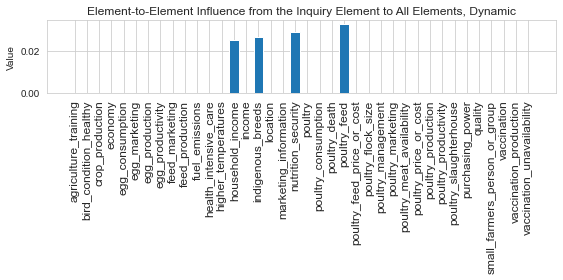

In [14]:
# return the element-to-element influence from the inquiry element to other elements
# sa.inquire_ETEI_from(element, model)
# plot the element-to-element influence from the inquiry element to all elements
ind = sa.inquire_element_index(element, Dmodel)
row = element_immediate_influences[ind]
fig_bar = plot_bar(
        row, 
        element_names, 
        'Element-to-Element Influence from the Inquiry Element to All Elements, Dynamic',)
display(fig_bar)

In [15]:
# return the element-to-element influence from other elements to the inquiry element
# Note: an empty result doesn't necessarily mean that the inquiry element is not influenced by any element in the network
# instead it means under this scenario, other elements' changes have little (statistically close to zero) probability of changing this element 
# it occurs when joint state where regulators affect regualted elements don't exist in this scenario
sa.inquire_ETEI_to(element, Dmodel)

[('egg_marketing', 0.02819144889330863),
 ('poultry_marketing', 0.0281906611550259),
 ('nutrition_security', 0.028163333333333325),
 ('location', 0.0018794036682777886),
 ('marketing_information', 0.0018794036682777886),
 ('poultry_production', 0.0018794036682777886),
 ('purchasing_power', 0.0010000644073142034),
 ('quality', 0.0009678042651428088),
 ('poultry_price_or_cost', 0.0009670165262786117),
 ('egg_production', 0.000960548327534344),
 ('poultry_slaughterhouse', 0.0009396887051675015),
 ('small_farmers_person_or_group', 0.0009396887051675015),
 ('poultry_consumption', 0.000843466799259722),
 ('household_income', 0.0008417404470124221),
 ('indigenous_breeds', 0.0008219303487882428),
 ('egg_consumption', 0.0008198346333333331),
 ('poultry_productivity', 7.760866878454002e-05),
 ('poultry_feed', 3.252769122021823e-05),
 ('poultry_feed_price_or_cost', 3.152262048673529e-05),
 ('poultry_flock_size', 2.9455214463840613e-05),
 ('poultry_meat_availability', 2.8115559975308644e-05),
 ('f

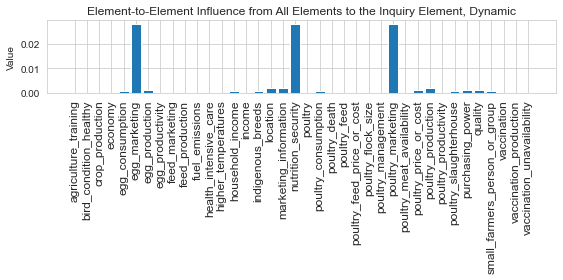

In [16]:
# plot the element-to-element influence from all elements to the inquiry element
ind = sa.inquire_element_index(element, Dmodel)
col = [element_element_influences[i][ind] for i in range(len(element_names))]
fig_bar = plot_bar(
        col, 
        element_names,
        'Element-to-Element Influence from All Elements to the Inquiry Element, Dynamic',)
display(fig_bar)

In [17]:
# return the element-to-element influence of any chosen node A to any chosen node B
# Note: an zero result doesn't necessarily mean that the inquiry element B is not influenced by element A
# instead it means under this scenario, A' changes have little (statistically close to zero) probability of changing B
B = 'income'
A = 'location'
sa.inquire_ETEI_from_to(A, B, Dmodel)

0.0018794036682777886

### 3.1.2 Visualize dynamic sensitivity analysis results for all elements (can be omitted)

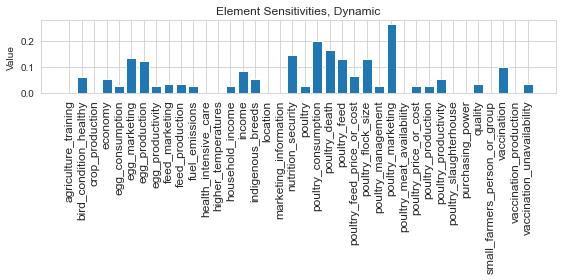

In [18]:
# plot element dynamic sensitivities
fig_bar = plot_bar(
        element_sensitivity, 
        element_names, 
        'Element Sensitivities, Dynamic'
        )
display(fig_bar)

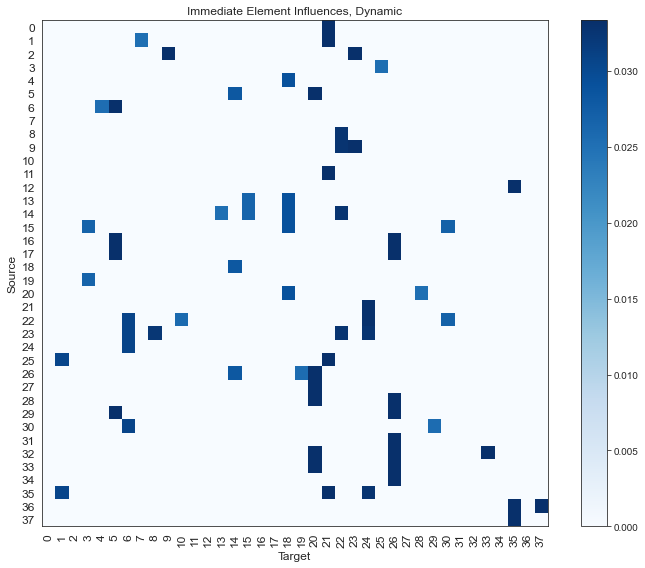

In [19]:
# plot immediate element influence matrix
fig_immediate = plot_matrix(
        element_immediate_influences, 
        range(len(element_names)), 
        range(len(element_names)), 
        'Immediate Element Influences, Dynamic'
        )
display(fig_immediate)

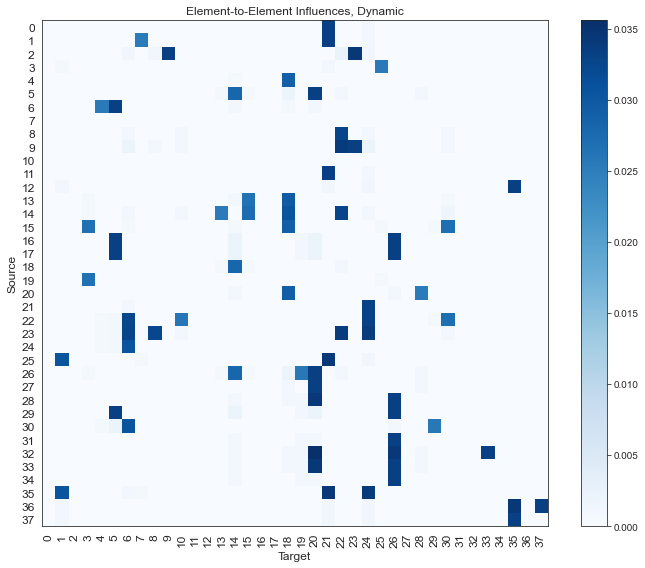

In [20]:
# plot element to element influence matrix
fig_etei = plot_matrix(
        element_element_influences, 
        range(len(element_names)), 
        range(len(element_names)), 
        'Element-to-Element Influences, Dynamic',
        color_scale='linear')
display(fig_etei)

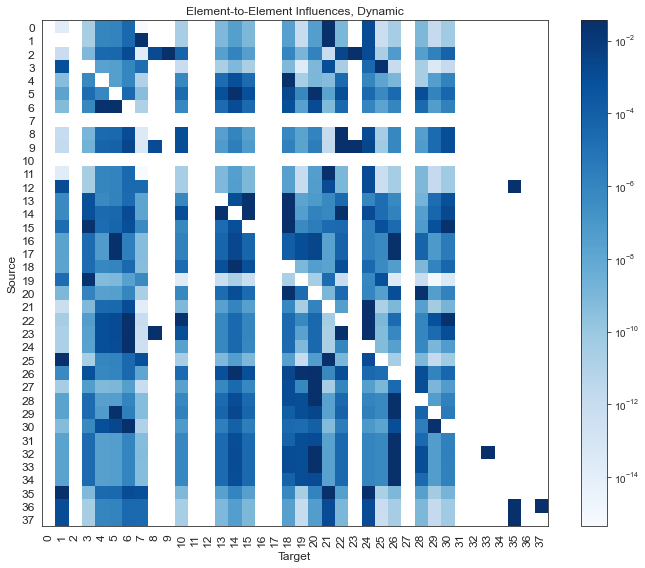

In [21]:
# plot element to element influence matrix
fig_etei = plot_matrix(
        element_element_influences, 
        range(len(element_names)), 
        range(len(element_names)), 
        'Element-to-Element Influences, Dynamic',
        color_scale='log')
display(fig_etei)

### 3.1.3 Extract dynamic sensitivity analysis pathways (should be tested)¶

In [22]:
# change source and target, number of paths to test different running time
# it should be pretty fast, less than 10 seconds

import time
start = time.time()
source = 'location' # it can be a node or list of nodes separated by commas
target = 'income'# it can be a node or list of nodes separated by commas
atts = 'influ'# influ OR sensi OR influ,sensi
n = 10 # the number of desired pathways, it is suggested to choose a number less than 15
pathway_result = sa.top_n_paths_from_to(source, target, n, atts, Dmodel)
end = time.time()
print('running time in sec:', end - start)

running time in sec: 0.13938617706298828


In [ ]:
pathway_result 

{'location to income in influ criterion': {'location,poultry_marketing,income': 6.970931765147649,
  'location,egg_marketing,income': 6.970931765147649,
  'location,poultry_marketing,poultry_consumption,nutrition_security,income': 13.908802668034408,
  'location,egg_marketing,poultry_consumption,nutrition_security,income': 13.908802668034408,
  'location,egg_marketing,poultry_consumption,poultry_price_or_cost,poultry_marketing,income': 17.45529657428496,
  'location,poultry_marketing,poultry,economy,poultry_management,poultry_death,poultry_flock_size,egg_production,egg_marketing,income': 31.627391021005945,
  'location,poultry_marketing,poultry,economy,poultry_management,bird_condition_healthy,poultry_death,poultry_flock_size,egg_production,egg_marketing,income': 35.11447314182527,
  'location,poultry_marketing,poultry,economy,poultry_management,poultry_death,poultry_flock_size,egg_production,egg_consumption,nutrition_security,income': 35.43541405339477,
  'location,poultry_marketing,p